# Summaries of CSO snow depth observations

2021-5-22. https://github.com/emiliom/

Generate summary information and plots of CSO snow depth observations for a user-defined period of time. This notebook can be re-run as desired to produce standardized summaries.

In [1]:
from datetime import datetime, timezone

import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

## CSO API request

In [2]:
date_start = '2020-6-30'
date_end = '2021-5-5'

params = {
  "startDate": date_start,
  "endDate": date_end,
  "format": "geojson",
  "limit": 100000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [3]:
obs_cso_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs='epsg:4326')

CSO `timestamp` was read as a string, not a datetime or timestamp.

In [4]:
obs_cso_gdf['timestamp'] = pd.to_datetime(obs_cso_gdf.timestamp)
obs_cso_gdf.sort_values('timestamp', ascending=False, inplace=True)

In [5]:
obs_cso_gdf.timestamp.min(), obs_cso_gdf.timestamp.max()

(Timestamp('2020-07-02 02:00:00+0000', tz='UTC'),
 Timestamp('2021-05-04 23:29:25.992000+0000', tz='UTC'))

## Generate summaries

### Number of individual submitters

In [6]:
len(obs_cso_gdf.author.unique())

1555

### Total observations

In [7]:
len(obs_cso_gdf)

7585

### By data source

In [8]:
obs_cso_gdf.source.value_counts()

SnowPilot      3440
regObs         2867
MountainHub    1278
Name: source, dtype: int64

### By month

**TODO**

### Map plot showing observations by country

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [10]:
obs_cso_countries_gdf = gpd.sjoin(obs_cso_gdf, world, how="inner")
obs_cso_countries_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,index_right,pop_est,continent,name,iso_a3,gdp_md_est
0,POINT (-151.66212 59.44492),v3iKgrDC,Erin Mckittrick,172.0,MountainHub,2021-05-04 23:29:25.992000+00:00,464.821625,4,326625791,North America,United States of America,USA,18560000.0
1,POINT (-151.67401 59.45491),zuHMmrDW,Erin Mckittrick,136.0,MountainHub,2021-05-04 23:00:32.688000+00:00,338.914948,4,326625791,North America,United States of America,USA,18560000.0
2,POINT (-120.06531 38.67496),I4auktiC,Benjamin Hatchett,60.0,MountainHub,2021-05-04 22:21:32.114000+00:00,2571.897949,4,326625791,North America,United States of America,USA,18560000.0
7,POINT (-113.71150 48.71625),4j4bjVNg,Zachary Miller,203.0,SnowPilot,2021-05-04 17:15:00+00:00,2294.267090,4,326625791,North America,United States of America,USA,18560000.0
16,POINT (-151.68551 59.45970),bj9e0r8m,Erin Mckittrick,60.0,MountainHub,2021-05-04 01:17:51.921000+00:00,142.721786,4,326625791,North America,United States of America,USA,18560000.0


Now do a group-by with count, on `name` (country name). Note that `iso_a3` has a corrupted (?) code of "-99" for 5 disparate countries, which corrupts the merge operation if used as the key.

In [11]:
bycountry_cnt = pd.DataFrame(obs_cso_countries_gdf.groupby('name')['name'].count())
bycountry_cnt.rename(columns={'name': 'cso_obs_count'}, inplace=True)
bycountry_cnt.head()

,cso_obs_count
name,
Antarctica,2
Argentina,27
Australia,1
Austria,2
Bulgaria,14


Merge this dataframe with `world`, to then generate the choropleth map by country

In [12]:
world = pd.merge(
    world, bycountry_cnt, how='left', 
    left_on=['name'], right_on=['name']
)
world['cso_obs_count'] = world['cso_obs_count'].fillna(0).astype(int)

In [13]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,cso_obs_count
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",331
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3356


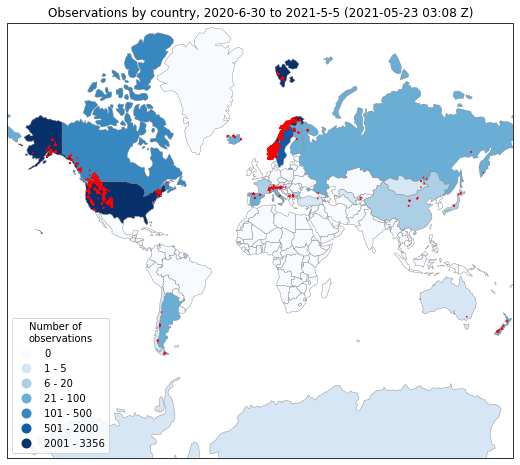

In [14]:
fig, ax = plt.subplots(
    figsize=(12, 8), subplot_kw={"projection": ccrs.Mercator()}
)

now_utc = datetime.utcnow().strftime("%Y-%m-%d %H:%M Z")
ax.set_title(f"Observations by country, {date_start} to {date_end} ({now_utc})")
world.plot(
    ax=ax, column='cso_obs_count', 
    scheme='user_defined', cmap=plt.cm.Blues, classification_kwds=dict(bins=[.999, 5.1, 20.1, 100.1, 500.1, 2000.1]),
    linewidth=0.4, edgecolor='gray', 
    legend=True, legend_kwds={
        "loc": "lower left", 
        "title": "Number of \nobservations",
        "fmt": "{:.0f}",
        "labels": [
            "0", 
            "1 - 5", 
            "6 - 20", 
            "21 - 100", 
            "101 - 500", 
            "501 - 2000", 
            f"2001 - {world.cso_obs_count.max()}"
        ]
    },
    transform=ccrs.PlateCarree()
)

obs_cso_gdf.plot(ax=ax, markersize=3, color='red', edgecolor='none', 
                 transform=ccrs.PlateCarree());

### Map plot showing observations by country for MountainHub only

**TODO**